<table align="center"><tr><th> <div style="width:600px"> <h4>AGH University of Krakow <br><br> Faculty of Computer Science, Electronics and Telecommunication <br><br> Institute of Electronics </h4></div></th><th> <div style="width:200px"><img src="./img/logo_agh.png" width="68" height="136"/></div> </th></tr></table>

---

<div style="text-align:center"><h3>CUSTOM SYSTEM DESIGN IN FPGA LABORATORY</h3></div>
<br>
<div style="text-align:center"><h1>Multi-cycle functional elements.<br>Newton-Raphson method for division</h1></div>
<br>

> **NOTE:** This tutorial demonstrates the validating process of the Newton-Raphson algorithm. For the exercise, we will use the PYNQ system with [AMD-Xilinx KRIA KV260](https://www.amd.com/en/products/system-on-modules/kria/k26/kv260-vision-starter-kit.html) development platform.
## Contents

* [Introduction](#Introduction)
* [Connection and communication with the development board](#Connection-and-communication-with-the-development-board)
* [Single-cycle multiplication](#Single-cycle-multiplication)
* [Paper-and-pencil multiplication](#Paper-and-pencil-multiplication)
* [Handshaking for the multi-cycle functional elements](#Handshaking-for-the-multi-cycle-functional-elements)
* [Multi-cycled multiplication](#Multi-cycled-multiplication)
* [Newton-Rapson division algorithm](#Newton-Rapson-division-algorithm)
* [Simulation using dedicated PYNQ hardware file](#Simulation-using-dedicated-PYNQ-hardware-file)
* [Analyze the obtained results from Newton-Raphson algorithm](#Analyze-the-obtained-results-from-Newton-Raphson-algorithm)

<div style="text-align:right"><h5> ver 0.2.1 </h5></div><br>


# Introduction

### Objectives

<ul>The main goal of this tutorial is to introduce the validation of results obtained from the FPGA systems we have constructed. <br>To perform the necessary operations, we will use the system we have built that utilizes the Newton-Raphson algorithm.
The case study for the problem of multi-cycling is Newton-Rapson algorithm for the division.
We will explain and implement the algorithm with Pynq in Jupyter Notebook.</ul>

### Prerequisites

<ul>Familiarity with the implementation code of the Newton-Raphson algorithm we have constructed is required. We expect the student to know the principles of operation of synchronous sequential circuits. Additionally, it is necessary to understand the basic concepts that are the foundation of any HDL, as well as basic Python programming skills.</ul>


# Connection and communication with the development board

**PYNQ Install**<br>
<ul>During the laboratory classes students get already prepared SD cards with Ubuntu and PYNQ setup.<br>
To install on your own SD card, just follow the instructions on the official [GitHub repository](https://github.com/Xilinx/Kria-PYNQ).</ul><br>

> **STEP 1:** Connect cables to the KRIA
>
>> A. Insert the microSD card to the J11<br>
>> B. Connect micro-USB cable to J4<br>
>> C. Connect RJ45 cable<br>
>> D. Connect power supply to J12<br>
>
> **WARNING:** After connecting to power supply the fan located at the KRIA board will start at full speed. It will slow down after correct boot of Ubuntu OS, in approx. 3 minuts.

<img src="./img/kria_plugs.png" width="300"/>


> **STEP 2:** Connect to the network
>
> PYNQ is working most efficient if it has access to the Internet. If available, you should connect your board to a network or router with Internet access. This will allow you to update your board and easily install new packages. There are two options:
>
>> LEFT option: Connect the KRIA with RJ45 directly to the PC (embedded network card, or dongle **USB<->Ethernet** included in the lab box)<br>
>> RIGHT option: Connet the KRIA to the router<br>

<img src="./img/kria_setup_network.png" width="800"/>

> You will need to have an Ethernet port available on your computer, and you will need to have permissions to configure your network interface. With a direct connection, you will be able to use PYNQ, but unless you can bridge the Ethernet connection to the board to an Internet connection on your computer, your board will not have Internet access. You will be unable to update or load new packages without Internet access.<br>
>
>> In the example below **Ethernet** is PC connection to LAN, and **Ethernet 3** is connection with KRIA. Use **View Network Connections** to set **Internet Connetion Sharing** option.<br>In case of no Received Bytes on **Ethernet 3** network, the best solution is to *disable and enable* network sharing in the **Ethernet** Properties tab.

<img src="./img/setup_ethernet.png" width="800"/>

> **STEP 3:** Open a USB Serial Terminal
>
>  You can use the terminal to check the network connection of the board. [PuTTY](https://www.putty.org/) is one application that can be used. To open a terminal, you will need to know the COM port for the board. Use 115200 baud rate. To login use data:
>
>> username: ubuntu<br>
>> password: kriasdup<br>
>
> You can check the HOSTNAME and IP address of the board using *ifconfig*. 
> In this example: 
>
>> HOSTNAME: kriaSDUP-0<br>
>> IPaddress: 192.168.137.227

<img src="./img/kria_putty.png" width="500"/>

> **STEP 4:** Connecting to Jupyter Notebook (LAB)
>
> Once your board is setup, to connect to Jupyter Notebooks open a web browser on your PC and navigate to:
>
>> [HOSTNAME:9090/lab](HOSTNAME:9090/lab) or <br>
>> [IPaddress:9090/lab](IPaddress:9090/lab)<br>
>
> To login use data:
>
>> password: xilinx<br>
>
> You can use drag-and-drop to copy files to the board.<br>
> To download file from the board use option File -> Download.

<img src="./img/kria_jupyter.png" width="600"/><br><br>

Starting from now you can work on a copy of this document.
Create your work folder (e.g., /sdup/student) and copy to it extracted archive newtwonRapson.zip, from [GitHub repository](https://github.com/arkadiuszrapacz/Newton_Rapson_kv260/) which consists of a Jupyter notebook file and a folder with images.
Then just open the notebook file on KRIA and go to the next step.


# Single-cycle-multiplication

## Reminder

<ul>Combinatorial digital systems implements logic gates only and no registers are used in the design.<br><br>
When multiplication is implemented as combinatorial logic, it can be performed in a single
clock cycle in the custom procesor. However, multipliction of integers is a complex operation,
and it usually introduce long delay paths if implemented in a combinatorial way.<br><br>
Fortunately, the FPGA designers can take advantege of combinatorial multiplication because
FPGAs features dedicated multiplier blocks. The maximum delay of such blocks is comparable
to the maximum FPGA clock cycle; therefore, they do not affect overal system performance.
For example, Xilinx's 7-series FPGAs feature 25×18 – bit multiplier blocks.<br><br>
The example code of simple 12×12 - bit multiplier is given below.</ul>

``` cpp
`timescale 1ns / 1ps
//////////////////////////////////////////////////////////////////////////////
// Filename: multiply12.sv
// Module Name: mul12
//////////////////////////////////////////////////////////////////////////////
module mul12(
    input logic[11:0] input0,
    input logic[11:0] input1,
    output logic[23:0] output0
);
always_comb begin
    output0 <= input0 * input1;
end
endmodule
```

## Multiplication Using Bit Shifting

Multiplication using bit shifting is a technique that utilizes bitwise operations to quickly compute the result of multiplying by powers of two.

Suppose we want to multiply a number `x` by `2^n`, where `n` is a positive integer. Instead of performing traditional multiplication, we can achieve the same result by using left bit shifting. This process involves shifting all bits of the number `x` to the left by `n` positions.

### Example

If `x = 5` and `n = 2`, then `x << n` shifts the binary representation of `5` (`101` in binary) two positions to the left, resulting in `10100` in binary, which is `20` in decimal.

### Applications

- **Efficiency**: Bit shifting is faster than traditional multiplication, especially in low-level programming.
- **Implementation**: It is commonly used in algorithms and data structures where performance optimization is critical.

Bit shifting is a powerful technique in computer science for efficiently handling operations involving powers of two.


## Exercise 1.1
<ul>Adjust the following code appropriately to achieve the CORRECT multiplication effect (using bit shifting).</ul>

In [1]:
def multiply_bitwise(num1_bit, num2_bit):

    num1 = int(num1_bit, 2)
    num2 = int(num2_bit, 2)
    
    result = 0
    
    while num2 > 0:
        if num2 & 1:
            result += num1

        num1 <<= 1 ## HERE
        num2 >>= 1  ## HERE
    
    result_bit = bin(result)[2:]
    
    return result_bit

# Example usage:
num1_bit = '101'  # Binary representation of 5
num2_bit = '110'  # Binary representation of 6

result = multiply_bitwise(num1_bit, num2_bit)
print(f"Result of {num1_bit} * {num2_bit} (binary): {result}")


Result of 101 * 110 (binary): 11110


# Paper-and-pencil multiplication

## Reminder
<ul>Paper-and-pencil method is widely used to perform manual multiplication of long digits. The
concept can be easily adopted as multiplication algorithm that allow split long registers into
shorter ones. The method is depicted in Figure 1.</ul>

<div style = "text-align:center;"> <img src="./img/paper_and_pencil.png" width="500"/> </div><br>

<ul>Here in the Figure 1, the registers a0, a1, b0, b1 are half the size of input aguments.
Conseguantly, reduced size multiplication can be performed. Partial products are summed up
to produce the final result.
The paper-and pencil algorithm is also given as System Verilog code below.</ul>

```cpp
`timescale 1ns / 1ps
////////////////////////////////////////////////////////////////////////////////
//
// Module Name: mul24_comb
// File: mul24_comb.sv
////////////////////////////////////////////////////////////////////////////////
//
module mul24_comb(
    input logic[23:0] input0,
    input logic[23:0] input1,
    output logic[47:0] output0
);
//Auxiliary signals
logic [11:0] a0, a1, b0, b1;
assign a0 = input0[11:0];
assign a1 = input0[23:12];
assign b0 = input1[11:0];
assign b1 = input1[23:12];
logic [23:0] tmp; // Tmp. result of fractional mul.
logic [47:0] result;
assign output0 = result;
always_comb begin
    //
    result = 48'h0;
    tmp = a0 * b0;
    // P0
    result[23:0] = tmp;
    tmp = a1 * b0;
    // P1
    result[35:12] = result[35:12] + tmp;
    tmp = a0 * b1;
    // P2
    result[36:12] = result[35:12] + tmp;
    tmp = a1 * b1;
    // DONE
    result[47:24] = result[47:24] + tmp;
end
endmodule
```

## Exercise 2.1
<ul>Below is the implementation of the Paper And Pencil algorithm using Python. The program divides the numbers input0 and input1 into lower (12 least significant bits) and upper (12 most significant bits) parts. The variable 'result' is responsible for accumulating the results of individual component results in the appropriate bit positions.</ul>

In [2]:
def PaP_mul(input0, input1):

    input0_a0 = input0 & 0b11           # 2 najmniej znaczące bity input0
    input0_a1 = (input0 >> 2) & 0b11    # kolejne 2 bity input0
    input1_b0 = input1 & 0b11           # 2 najmniej znaczące bity input1
    input1_b1 = (input1 >> 2) & 0b11    # kolejne 2 bity input1

    result = 0
    tmp = 0

    # P0
    tmp = input0_a0 * input1_b0
    result |= tmp  
    
    # P1
    tmp = input0_a1 * input1_b0
    result |= (tmp << 2)  
    
    # P2
    tmp = input0_a0 * input1_b1
    result |= (tmp << 2)  

    # DONE
    tmp = input0_a1 * input1_b1
    result |= (tmp << 4)  

    return result


input0 = int('1100', 2) 
input1 = int('1010', 2)  

output0 = PaP_mul(input0, input1)

print(f"input0 = {bin(input0)[2:]}")
print(f"input1 = {bin(input1)[2:]}")
print(f"output0 = {bin(output0)[2:]}")  


input0 = 1100
input1 = 1010
output0 = 1111000


```cpp
module multi_cycle_fun(
    input logic clk,
    input logic ,
    output logic ready,
    // inputs
    input logic [bit_width0-1:0] input0,
    input logic [bit_width1-1:0] input1,
    ...
    // outputs
    output logic [bit_width1-1:0] output0,
    ...
);
```

<ul>When the input signal is active, it indicates that the input data is valid. If the multifunctional unit is idle, it starts its internal processing immediately upon activation. Once the processing is finished, the ready signal is asserted. The method is presented in the Figure 2.</ul>

<div style = "text-align:center;"> <img src="./img/handshaking.png" width="500"/> </div><br>

<ul>The corresponding Verilog code is given below.</ul>

```cpp
//FSM template for handshaking signals
enum {IDLE=0, P0, P1, P2, DONE} state;
    always_ff @(posedge clk) begin: fsm
        case(state)
            IDLE: begin
                ready <= 1'b0;
                state <= P0;
                // other alg. related ops.
            end
                P0: begin
                // other alg. related ops.
                state <= P1;
            end
            P1: begin
                // alg. related ops.
                // other alg. related ops.
            end
            .
            .
            .
            .
            Pn: begin
                // alg. related ops.
                state <= DONE;
            end
            DONE: begin
                // other alg. related ops.ready <= 1'b1;
                ready <= 1'b1;
                state <= IDLE;
            end
        endcase
    end: fsm   
```

# Multi-cycled multiplication

<ul>Now, as we have had prepared the template for multi-cycle elements, we can prepare the multi-cycled paper-and-pencil multiplier.</ul>

```cpp
`timescale 1ns / 1ps
////////////////////////////////////////////////////////////////////////////////
// Module Name: mul24_inf
// File Namee: mul24_inf.sv
////////////////////////////////////////////////////////////////////////////////
module mul24_infer(
    input logic clk,
    input logic ,
    output logic ready,
    input logic[23:0] input0,
    input logic[23:0] input1,
    output logic[47:0] output0
);
//Auxiliary signals
logic [11:0] a0, a1, b0, b1; // a0 = low(input0); a1 = high(input0); b0 =
low(input2); ...
assign a0 = input0[11:0];
assign a1 = input0[23:12];
assign b0 = input1[11:0];
assign b1 = input1[23:12];
logic [23:0] tmp; // Tmp. result of fractional mul.
logic [47:0] result;
assign output0 = result;
//FSM
enum {IDLE=0, P0, P1, P2, DONE} state;
    always_ff @(posedge clk) begin: fsm
        case(state)
            IDLE: begin
                ready <= 1'b0;
                if ( == 1'b0) begin
                    state <= IDLE;
                end else begin
                    result <= 48'h0;
                    tmp <= a0 * b0;
                    state <= P0;
                end
            end
            P0: begin
                result[23:0] <= tmp;
                tmp <= a1 * b0;
                state <= P1;
            end
            P1: begin
                result[35:12] <= result[35:12] + tmp;
                tmp <= a0 * b1;
                state <= P2;
            end
            P2: begin
                result[36:12] <= result[36:12] + tmp;
                tmp <= a1*b1;
                state <= DONE;
            end
            DONE: begin
                result[47:24] <= result[47:24] + tmp;
                ready <= 1'b1;
                state <= IDLE;
            end
        endcase
    end: fsm
endmodule
```

<div style = "text-align:center;"> <img src="./img/machine_state.png" width="500"/> </div><br>


In [3]:
def multi_cycled_mul(input0, input1):
    a0 = input0 & 0xFFF
    a1 = (input0 >> 12) & 0xFFF
    b0 = input1 & 0xFFF
    b1 = (input1 >> 12) & 0xFFF
    
    tmp = a0 * b0
    result = tmp
    tmp = a1 * b0
    result += tmp << 12
    tmp = a0 * b1
    result += tmp << 12
    tmp = a1 * b1
    result += tmp << 24
    
    return result

# Test the function
input0 = 0xFFFFFF  
input1 = 0xFFFFFF  

output = multi_cycled_mul(input0, input1)
print(f"Output: {output:#0{14}x}") 


Output: 0xfffffe000001


# Newton-Rapson division algorithm
The division $$ \frac{a}{b} $$ can be seen as multiplication $$ a*\frac{1}{b} $$ Therefore, the algorithm presented
here is an algorithm for $$ f(d) = \frac{1}{d} $$ function.



## Newton method

Newton's Method is used to find successive approximations to the roots of a function.

<div style = "text-align:center;"> <img src="./img/newton.png" width="500"/> </div><br>

Taken, the approximate root value $x_{1}$ of the function is know, it is possible to find a better approximation $x_{i+1}$,if the formula $x_{i+1}=x_{i}-\frac{f(x_{i})}{f^{'}(x_{i}}$ is applied. <br> To find reciprocal of the value d, we will apply the N-R method fo find root of the function $f(x)=\frac{1}{x}-d$ . Because, the derivative of the function $\frac{1}{x}-d$ is $f'(x)=-\frac{1}{x^{2}}$, the N-R formula for the reciprocal takes the form $x_{i+1}=x_{i}*(2-d*x_{i})$. The only problem that remains, is to find initial value $x_{0}$ to start iteration. Here, we will use the linear approximation of the $\frac{1}{d}$ function in range (0, 1]:
$$x_{0} = -1.88235*d+2.82353$$
Putting together, scaling, linear approximation, and the N-R iterations, it is possible to
formulate the algoritm.

```cpp
`timescale 1ns / 1ps
////////////////////////////////////////////////////////////////////////////////
// Design Name:
// Module Name: reciprocal_beh
// File Name: reciprocal_beh.sv
////////////////////////////////////////////////////////////////////////////////
module en_reciprocal_beh(
    input logic [15:0] input0, // argument: integer [15:0]
    output logic [4:-19] output0 // result: fixed point [5:19] representation
);
// Constants
logic [4:-19] A = 24'h0F0F0D; // Fixed point [5:19] representation of 1.88235
logic [4:-19] B = 24'h169696; // Fixed point [5:19] representation of 2,82353
logic [4:-19] HALF = 32'h040000; // Fixed point [4:19] representation of 0.5
logic [4:-19] TWO = 32'h100000; // Fixed point [4:19] representation of 2
// Variables
logic [4:0] scaling; // Keeps scaling factor
logic [9:-38] mulResult; // Temporary result of multiplication [5:19] * [5;19]
logic [4:-19] scaledVal;
logic [4:-19] approxVal;
logic [4:-19] newVal;
real resultFP; // To display human readable
always_comb begin
    // Here scaledVal = input / 2**19 for different data representations
    scaledVal = input0; // IDLE
    // therefore scaling starts from maximum value and goes backwards
    scaling = 19;
    // Scale tmpValue to range [0.5, 1] i.e. [0x080000, 0x040000] in integer
    // In difference to oryginal algorithm we multiply by two in each iteration
    while( scaledVal < HALF ) begin // COMP_AND_SCALE
        scaledVal = scaledVal << 1; // Multiply by two i.e. LSR
        scaling --;
    end
    // Take Linear aproximation x0 = 2.82353 - 1.88235 * d.
    mulResult = scaledVal * A; // Result is fixpoint [10:38]. MUL_A
    approxVal = mulResult >> 19; // keep [4:19] fxp format
    approxVal = B - approxVal; // SUB_B
    while(1) begin // iterate: x(i+1) = x(i) * ( 2 - x(i)*d )
        mulResult = approxVal * scaledVal; // MUL_SCALED
        newVal = mulResult >> 19; // keep [4:19] fxp format
        newVal = TWO - newVal; // SUB_2
        mulResult = approxVal * newVal; // MUL_NEW
        newVal = mulResult >> 19; // keep [4:19] fxp format
        if( approxVal == newVal ) begin break; end // CHECK_EQ
        approxVal = newVal; // ASSIGN_NEW
    end
    // Denormalize back to oryginal range
    approxVal = approxVal >> scaling;
    output0 = approxVal;
    // Print result
    $display("Binary result is = %b", approxVal);
    resultFP = approxVal;
    resultFP = resultFP / 2**19;
    $display("Real value is = %f", resultFP);
end
endmodule
```

## Python simulation
<ul>The code below simulates the algorithm for calculating the reciprocal of a number using fixed-point arithmetic with iterative loops and bitwise operations. It shifts the input value input0 into the appropriate range, applies linear and iterative approximation, and then outputs the result in binary form and as a floating-point number.</ul>

In [4]:
def reciprocal_behavior(input0):
    A = 0x0F0F0D  # Fixed point [5:19] representation of 1.88235
    B = 0x169696  # Fixed point [5:19] representation of 2.82353
    HALF = 0x040000  # Fixed point [4:19] representation of 0.5
    TWO = 0x100000  # Fixed point [4:19] representation of 2
    
    scaling = 19
    scaledVal = input0
    
    while scaledVal < HALF:
        scaledVal <<= 1 # HERE (should be 1)
        scaling -= 1
    
    # Linear approximation x0 = 2.82353 - 1.88235 * d
    mulResult = scaledVal * A
    approxVal = mulResult >> 19
    approxVal = B - approxVal
    
    # Iterative approximation: x(i+1) = x(i) * (2 - x(i) * d)
    while True:
        mulResult = approxVal * scaledVal
        newVal = mulResult >> 19
        newVal = TWO - newVal
        
        mulResult = approxVal * newVal
        newVal = mulResult >> 19
        
        if approxVal == newVal:
            break
        
        approxVal = newVal
    
    # Denormalize back to original range
    approxVal >>= scaling
    
    # Print results (binary and real)
    print(f"Binary result is = {approxVal:022b}")
    resultFP = approxVal / float(1 << 19)
    print(f"Real value is = {resultFP:.6f}")

# Example usage
if __name__ == "__main__":
    input0 = 0x3322  # Example input value in hexadecimal
    reciprocal_behavior(input0)


Binary result is = 0000000000000000101000
Real value is = 0.000076


# Simulation using dedicated PYNQ hardware file

## Downloading .xsa file

In [5]:
from pynq import Overlay

n_rap_ov = Overlay("newton_rap.xsa")
n_rap = n_rap_ov.new_rap_0.mmio

## Adding offsets to the values we read from PYNQ

In [6]:
start_of = 8
ready_of = 12
input_of = 16
output_of = 4

## Analysis of the algorithm operation using PYNQ

In [7]:
import numpy as np

input_num = 2
output_num = 0

# Run IP module
n_rap.write(input_of, input_num)
n_rap.write(start_of, 1)

while (n_rap.read(ready_of) == 0):
    pass

output_num = n_rap.read(output_of)

# Read the output value
print(output_num / 524288)  # 524288 is used to bit shift the value

0.5


## Generating next input values for the Newton-Rapson division algorithm

In [8]:
import matplotlib.pyplot as plt

num_iterations = 500 #Values range from 1-65535 but very high values will calculate for a long time

input_value = []
output_value = []
expected_output_value = []
difference = []

for i in range(num_iterations):

    input_num = 1 + i
    output_num = 0

    n_rap.write(input_of, input_num)
    n_rap.write(start_of, 1)

    while (n_rap.read(ready_of) == 0):
        pass

    output_num = n_rap.read(output_of)

    input_value.append(input_num)
    output_value.append(output_num/524288)
    expected_output_value.append(1 / input_num)
    difference.append((abs(output_value[i] - expected_output_value[i]) / expected_output_value[i]) * 100)

## Plotting values on graphs

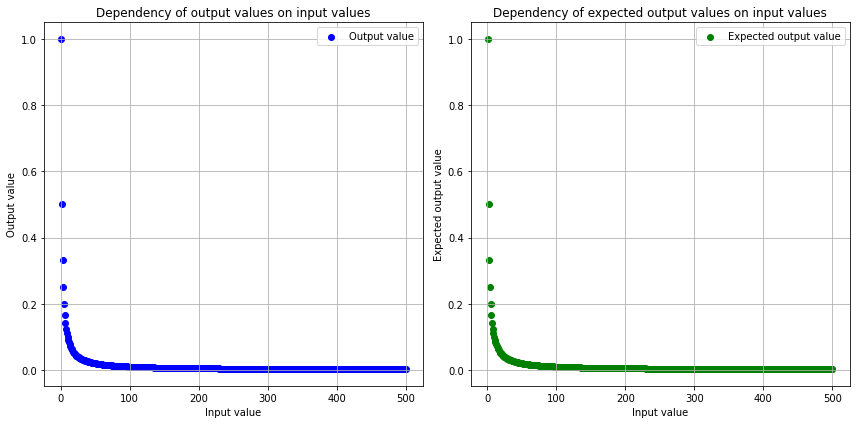

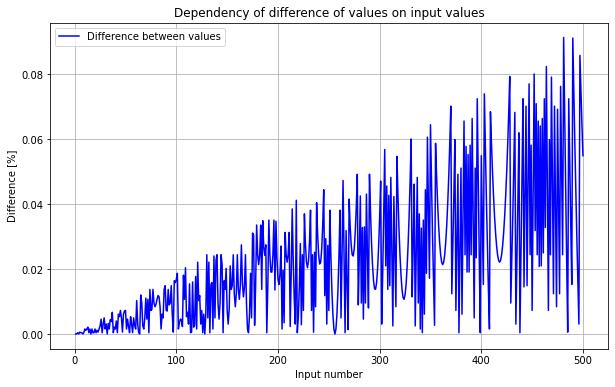

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(input_value, output_value, color='blue', label='Output value')
plt.title('Dependency of output values on input values')
plt.xlabel('Input value')
plt.ylabel('Output value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(input_value, expected_output_value, color='green', label='Expected output value')
plt.title('Dependency of expected output values on input values')
plt.xlabel('Input value')
plt.ylabel('Expected output value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(input_value, difference, label='Difference between values', color='blue')
plt.xlabel('Input number')
plt.ylabel('Difference [%]')
plt.title('Dependency of difference of values on input values')
plt.legend()
plt.grid(True)
plt.show()

# Analyze the obtained results from Newton-Raphson algorithm

# Downloading .csv file

## Downloading Pandas library to collect .csv files

To download Pandas write the code below into cmd on PuTTY (Ubuntu system present on Kria board)
```bash
sudo pip3 install pandas
```

In [10]:
import pandas as pd

df = pd.read_csv('simulation_output.csv')

print(df)


     Time   clk   input    output     check
0    5125     1     1.0  1.000000  1.000000
1   10225     1     2.0  0.500000  0.500000
2   14575     1     3.0  0.333332  0.333333
3   19625     1     4.0  0.250000  0.250000
4   23925     1     5.0  0.199999  0.200000
5   28225     1     6.0  0.166666  0.166667
6   32525     1     7.0  0.142857  0.142857
7   37525     1     8.0  0.125000  0.125000
8   41025     1     9.0  0.111111  0.111111
9   45275     1    10.0  0.099998  0.100000
10  49525     1    11.0  0.090908  0.090909
11  53775     1    12.0  0.083332  0.083333
12  58775     1    13.0  0.076921  0.076923
13  63025     1    14.0  0.071428  0.071429
14  67275     1    15.0  0.066666  0.066667
15  72225     1    16.0  0.062500  0.062500
16  77175     1    17.0  0.058823  0.058824
17  80625     1    18.0  0.055555  0.055556
18  84825     1    19.0  0.052631  0.052632
19  89025     1    20.0  0.049999  0.050000
20  93225     1    21.0  0.047619  0.047619
21  97425     1    22.0  0.04545

<ul>The algorithm reacts to the appearance of a new output value. As observed, the received inverse value using the algorithm aligns with the expected values. The table contains information about the time of receiving the new information, the slope to which the algorithm responds, the input value, the output value, and the expected output value.</ul>

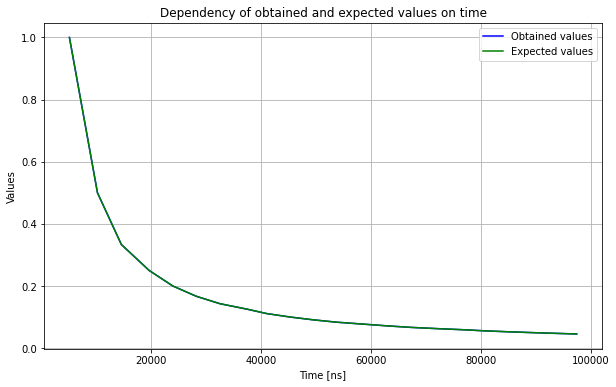

The amount of required clock cycles:  [ 102.  204.  291.  392.  478.  564.  650.  750.  820.  905.  990. 1075.
 1175. 1260. 1345. 1444. 1543. 1612. 1696. 1780. 1864. 1948.] 

The difference between the obtained output value and the expected value in %:
 [0.         0.         0.0003     0.         0.0005     0.0006
 0.         0.         0.         0.00200004 0.00110001 0.00120002
 0.00260007 0.00140001 0.00150002 0.         0.00170002 0.00180002
 0.00190002 0.00200004 0.         0.00220003]


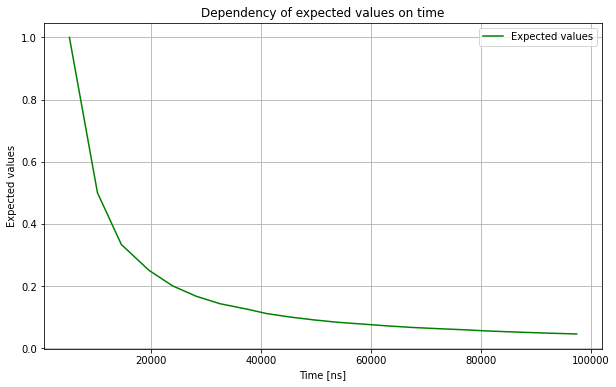

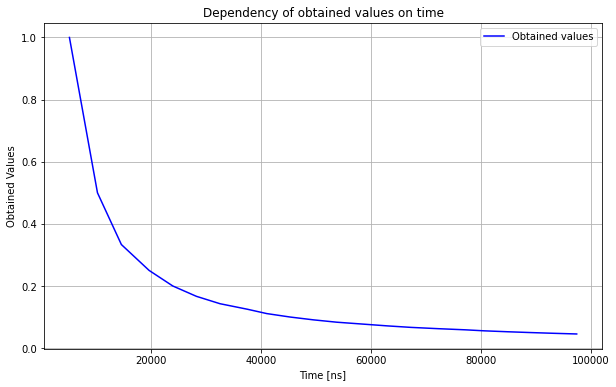

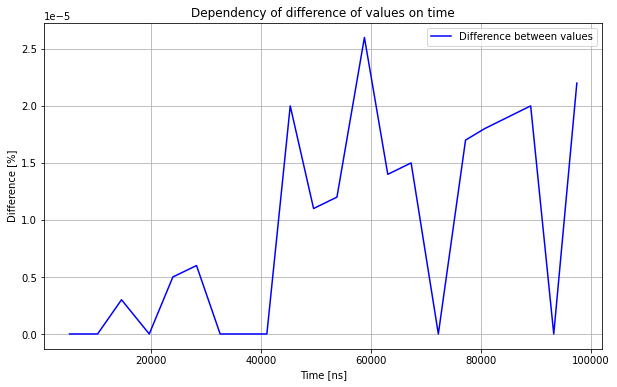

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('simulation_output.csv')

matrix = df.values

output = matrix[:, 3]
time = matrix[:, 0]
cycle = (time-25)/50
check = matrix[:, 4]
diff = abs(matrix[:, 3] - matrix[:, 4])/matrix[:, 3]

plt.figure(figsize=(10, 6))
plt.plot(time, output, label='Obtained values', color='blue')
plt.plot(time, check, label='Expected values', color='green')
plt.xlabel('Time [ns]')
plt.ylabel('Values')
plt.title('Dependency of obtained and expected values on time')
plt.legend()
plt.grid(True)
plt.show()

print("The amount of required clock cycles: ", cycle, "\n")
print("The difference between the obtained output value and the expected value in %:\n", diff*100)

plt.figure(figsize=(10, 6))
plt.plot(time, check, label='Expected values', color='green')
plt.xlabel('Time [ns]')
plt.ylabel('Expected values')
plt.title('Dependency of expected values on time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time, output, label='Obtained values', color='blue')
plt.xlabel('Time [ns]')
plt.ylabel('Obtained Values')
plt.title('Dependency of obtained values on time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time, diff, label='Difference between values', color='blue')
plt.xlabel('Time [ns]')
plt.ylabel('Difference [%]')
plt.title('Dependency of difference of values on time')
plt.legend()
plt.grid(True)
plt.show()
